Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔝 Top 10 most consumed materials:
                    Item Code  \
19              R_03_01_02_14   
2     R_02_05_02_01_01_33_305   
91              R_04_01_02_14   
173             R_07_03_07_13   
190  R_07_05_03_02_01_33_2239   
24         R_03_02_07_14_1188   
1     R_02_05_02_01_01_33_294   
290       R_08_03_07_13_06_33   
198   R_07_05_03_02_01_33_793   
4     R_02_05_02_01_01_33_373   

                                                  Item  Consumption Value  
19                  [R_03_01_02_14] M#4 BRASS WIRE DN+       1.604699e+06  
2    [R_02_05_02_01_01_33_305] SLIDER S/L M#4.5 TEX...       5.961130e+05  
91                  [R_04_01_02_14] M#5 BRASS WIRE DN+       4.676373e+05  
173                     [R_07_03_07_13] N#3 LONG CHAIN       3.265127e+05  
190  [R_07_05_03_02_01_33_2239] C#3 SLIDER ZINC REG...       2.815238e+05  
24   [R_03_02_07_

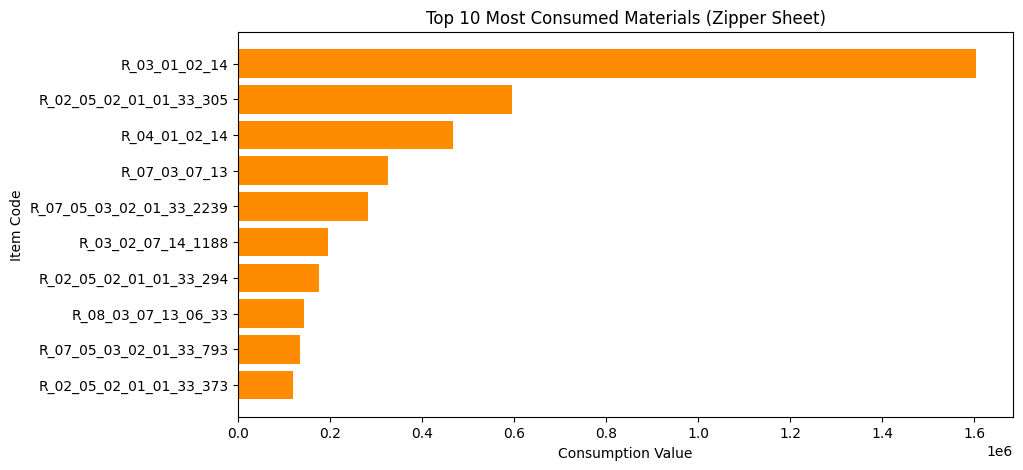

In [ ]:
# ===== Setup (deps) =====
import os
import base64
import pandas as pd
import matplotlib.pyplot as plt
import gspread
from gspread_dataframe import get_as_dataframe
from google.oauth2.service_account import Credentials

# Pretty printing (optional)
pd.options.display.float_format = "{:,.2f}".format

# ===== Config =====
SHEET_URL  = "https://docs.google.com/spreadsheets/d/1tSgmESOWqYRkDk_KhewnaaJmQGSUaSILzOzpade9tRc/edit?gid=0#gid=0"
SHEET_TAB  = "Zipper"  # change to "Zipper" if you want that tab
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive",
]

# Prefer the creds file created by the workflow; fallback to env base64 if present
SA_PATH = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS", "service_account.json")
if not os.path.exists(SA_PATH):
    b64 = os.environ.get("GCP_SERVICE_ACCOUNT_B64")
    if b64:  # optional fallback path
        with open(SA_PATH, "wb") as f:
            f.write(base64.b64decode(b64))
    else:
        raise FileNotFoundError(f"Service account JSON not found at {SA_PATH}")

# ===== Auth =====
creds = Credentials.from_service_account_file(SA_PATH, scopes=SCOPES)
gc = gspread.authorize(creds)

# ===== Load data =====
sh = gc.open_by_url(SHEET_URL)
ws = sh.worksheet(SHEET_TAB)

df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
df = df.dropna(how="all").reset_index(drop=True)

# Ensure numeric columns
NUMERIC_COLS = [
    "Opening Quantity", "Opening Value", "Receive Quantity", "Receive Value",
    "Issue Quantity", "Issue Value", "Closing Quantity", "Closing Value"
]
for col in NUMERIC_COLS:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
df[NUMERIC_COLS] = df[NUMERIC_COLS].fillna(0)

# ===== Consumption calc =====
# Treat Issue Value (usually negative for outflow) as positive consumption
df["Consumption Value"] = df["Issue Value"].abs()

# Total consumption across the whole sheet
total_consumption = float(df["Consumption Value"].sum())

# Group & rank by Item Code + Item
summary = (
    df.groupby(["Item Code", "Item"], as_index=False)["Consumption Value"].sum()
      .sort_values("Consumption Value", ascending=False)
)
summary["% of Total"] = (summary["Consumption Value"] / (total_consumption if total_consumption else 1) * 100).round(2)

top_10 = summary.head(10)

# ===== Output =====
print("🔝 Top 10 most consumed materials (Metal):")
print(top_10)

print(f"\n📊 TOTAL consumption across all items: {total_consumption:,.2f}")

# Plot (saved into the executed notebook; no explicit colors/styles)
plt.figure(figsize=(10, 6))
plt.barh(top_10["Item Code"], top_10["Consumption Value"])
plt.gca().invert_yaxis()
plt.xlabel("Consumption Value")
plt.ylabel("Item Code")
plt.title("Top 10 Most Consumed Materials (Metal)")
plt.tight_layout()
plt.show()


In [15]:
# ✅ Step 1: Extract Top 10 codes + consumption values from first sheet
top_dict = dict(zip(top_10["Item Code"], top_10["Consumption Value"]))

# ✅ Step 2: Open Helper sheet
HELPER_SHEET_URL = "https://docs.google.com/spreadsheets/d/1fnOSIWQa_mbfMHdgPatjYEIhG3kQlzPy0djHG8TOszk/edit?gid=136222578#gid=136222578"
helper_sh = gc.open_by_url(HELPER_SHEET_URL)
helper_ws = helper_sh.worksheet("Zipper Helper -Do not open")

# ✅ Step 3: Read Item Codes from col D
item_codes = helper_ws.col_values(4)[1:]  # skip header row (D2:D)
start_row = 2  # because we skip header

# ✅ Step 4: Build output values for col F
output_vals = []
for code in item_codes:
    val = top_dict.get(code, "")  # if code exists in Top 10 dict → value else blank
    output_vals.append([val])

# ✅ Step 5: Write into col F (F2:F)
helper_ws.update(f"F{start_row}:F{start_row+len(output_vals)-1}", output_vals)

print("✅ Matching done. Consumption values pasted into column F.")


/tmp/ipython-input-2662820353.py:20: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  helper_ws.update(f"F{start_row}:F{start_row+len(output_vals)-1}", output_vals)


✅ Matching done. Consumption values pasted into column F.


In [16]:
################################################# Metal ##################################################

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔝 Top 10 most consumed materials:
          Item Code                                               Item  \
30   R_1_003_03_181                     [R_1_003_03_181] zinc alloy-z5   
17   R_1_001_01_029       [R_1_001_01_029] Brass Strip-0.23x305mm-hard   
28   R_1_002_03_656  [R_1_002_03_656] Zinc Alloy Strip-0.30x160mm-Soft   
26   R_1_002_01_034       [R_1_002_01_034] Brass Strip-0.30x305mm-soft   
109  R_1_007_01_157           [R_1_007_01_157] 12mm-socket-spring type   
23   R_1_001_05_617               [R_1_001_05_617] SS Strip-0.23x305mm   
279  R_1_015_00_327    [R_1_015_00_327] Thinner-NC-Thinner for Lacquer   
84   R_1_006_05_618  [R_1_006_05_618] 17mm Temper Shank With Plasti...   
25   R_1_002_01_031       [R_1_002_01_031] Brass Strip-0.25x305mm-soft   
248  R_1_015_00_247                     [R_1_015_00_247] GIBONOL C-115   

     Consumption Value

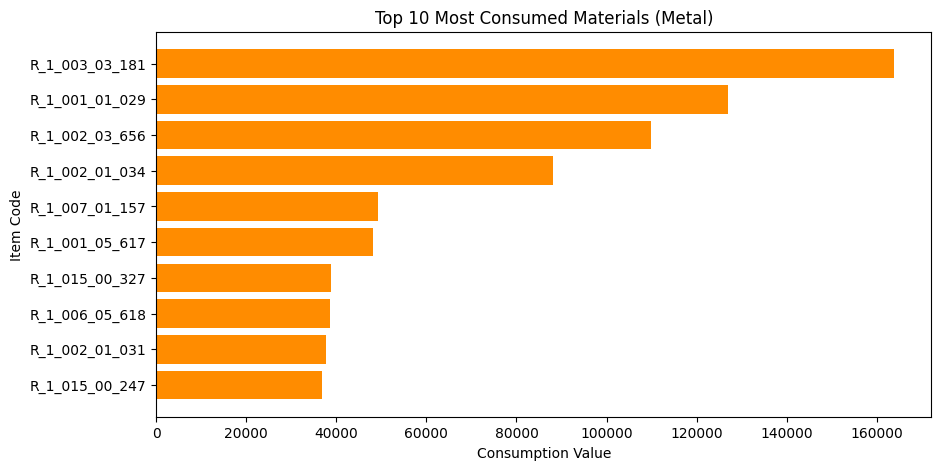

In [ ]:
# ===== Setup (deps) =====
import os
import base64
import pandas as pd
import matplotlib.pyplot as plt
import gspread
from gspread_dataframe import get_as_dataframe
from google.oauth2.service_account import Credentials

# Pretty printing (optional)
pd.options.display.float_format = "{:,.2f}".format

# ===== Config =====
SHEET_URL  = "https://docs.google.com/spreadsheets/d/1tSgmESOWqYRkDk_KhewnaaJmQGSUaSILzOzpade9tRc/edit?gid=0#gid=0"
SHEET_TAB  = "Metal"  # change to "Zipper" if you want that tab
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive",
]

# Prefer the creds file created by the workflow; fallback to env base64 if present
SA_PATH = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS", "service_account.json")
if not os.path.exists(SA_PATH):
    b64 = os.environ.get("GCP_SERVICE_ACCOUNT_B64")
    if b64:  # optional fallback path
        with open(SA_PATH, "wb") as f:
            f.write(base64.b64decode(b64))
    else:
        raise FileNotFoundError(f"Service account JSON not found at {SA_PATH}")

# ===== Auth =====
creds = Credentials.from_service_account_file(SA_PATH, scopes=SCOPES)
gc = gspread.authorize(creds)

# ===== Load data =====
sh = gc.open_by_url(SHEET_URL)
ws = sh.worksheet(SHEET_TAB)

df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
df = df.dropna(how="all").reset_index(drop=True)

# Ensure numeric columns
NUMERIC_COLS = [
    "Opening Quantity", "Opening Value", "Receive Quantity", "Receive Value",
    "Issue Quantity", "Issue Value", "Closing Quantity", "Closing Value"
]
for col in NUMERIC_COLS:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
df[NUMERIC_COLS] = df[NUMERIC_COLS].fillna(0)

# ===== Consumption calc =====
# Treat Issue Value (usually negative for outflow) as positive consumption
df["Consumption Value"] = df["Issue Value"].abs()

# Total consumption across the whole sheet
total_consumption = float(df["Consumption Value"].sum())

# Group & rank by Item Code + Item
summary = (
    df.groupby(["Item Code", "Item"], as_index=False)["Consumption Value"].sum()
      .sort_values("Consumption Value", ascending=False)
)
summary["% of Total"] = (summary["Consumption Value"] / (total_consumption if total_consumption else 1) * 100).round(2)

top_10 = summary.head(10)

# ===== Output =====
print("🔝 Top 10 most consumed materials (Metal):")
print(top_10)

print(f"\n📊 TOTAL consumption across all items: {total_consumption:,.2f}")

# Plot (saved into the executed notebook; no explicit colors/styles)
plt.figure(figsize=(10, 6))
plt.barh(top_10["Item Code"], top_10["Consumption Value"])
plt.gca().invert_yaxis()
plt.xlabel("Consumption Value")
plt.ylabel("Item Code")
plt.title("Top 10 Most Consumed Materials (Metal)")
plt.tight_layout()
plt.show()


In [18]:
# ✅ Step 1: Extract Top 10 codes + consumption values from first sheet
top_dict = dict(zip(top_10["Item Code"], top_10["Consumption Value"]))

# ✅ Step 2: Open Helper sheet
HELPER_SHEET_URL = "https://docs.google.com/spreadsheets/d/1fnOSIWQa_mbfMHdgPatjYEIhG3kQlzPy0djHG8TOszk/edit?gid=136222578#gid=136222578"
helper_sh = gc.open_by_url(HELPER_SHEET_URL)
helper_ws = helper_sh.worksheet("Metal Helper -Do not open")

# ✅ Step 3: Read Item Codes from col D
item_codes = helper_ws.col_values(4)[1:]  # skip header row (D2:D)
start_row = 2  # because we skip header

# ✅ Step 4: Build output values for col F
output_vals = []
for code in item_codes:
    val = top_dict.get(code, "")  # if code exists in Top 10 dict → value else blank
    output_vals.append([val])

# ✅ Step 5: Write into col F (F2:F)
helper_ws.update(f"F{start_row}:F{start_row+len(output_vals)-1}", output_vals)

print("✅ Matching done. Consumption values pasted into column F.")


/tmp/ipython-input-528792517.py:20: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  helper_ws.update(f"F{start_row}:F{start_row+len(output_vals)-1}", output_vals)


✅ Matching done. Consumption values pasted into column F.


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Top-10 RM Forecast -> Helper Sheet Column G

What it does
------------
1) Auth to Google Sheets using GOOGLE_APPLICATION_CREDENTIALS or Base64 fallback.
2) Load the main "Zipper" sheet and compute a naive 10-day forecast per Item Code:
      forecast = mean( last 7 days' daily consumption ) * 10
3) Select Top 10 Item Codes by forecast value.
4) Load the helper sheet ("Zipper Helper -Do not open") and, for each row's RM Code.1:
      - If the RM Code.1 is in the Top-10 map, write its forecast to column G.
      - Otherwise write an empty string to clear it.
5) Writes exactly G2:G{N} where N = number of data rows in helper sheet.

Env Vars (recommended)
----------------------
- GOOGLE_APPLICATION_CREDENTIALS : path to service account JSON (preferred)
- GCP_SERVICE_ACCOUNT_B64        : Base64-encoded service account JSON (fallback)
- MAIN_SHEET_URL                 : Google Sheet URL for main stock sheet
- MAIN_WORKSHEET_NAME            : Worksheet name in main sheet (default "Zipper")
- HELPER_SHEET_URL               : Google Sheet URL for helper sheet
- HELPER_WORKSHEET_NAME          : Worksheet name in helper sheet (default "Zipper Helper -Do not open")
- TOP_N                          : number of RM codes to keep (default 10)
- LOOKBACK_DAYS                  : days to compute rolling mean from (default 7)
- HORIZON_DAYS                   : forecast horizon in days (default 10)
- TARGET_COLUMN_LETTER           : column to write in helper (default "G")

Requirements
------------
pip install pandas numpy gspread gspread-dataframe google-auth
"""

import os
import base64
import sys
from typing import Dict

import pandas as pd
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from google.oauth2.service_account import Credentials


def ensure_service_account() -> str:
    """
    Prefer GOOGLE_APPLICATION_CREDENTIALS if present.
    Otherwise try GCP_SERVICE_ACCOUNT_B64 and write to 'service_account.json'.
    """
    sa_path = os.environ.get("GOOGLE_APPLICATIONS_CREDENTIALS")  # common typo safeguard
    if sa_path and os.path.exists(sa_path):
        return sa_path

    sa_path = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS", "service_account.json")
    if os.path.exists(sa_path):
        return sa_path

    b64 = os.environ.get("GCP_SERVICE_ACCOUNT_B64")
    if b64:
        with open(sa_path, "wb") as f:
            f.write(base64.b64decode(b64))
        return sa_path

    raise FileNotFoundError(f"Service account JSON not found at {sa_path} and GCP_SERVICE_ACCOUNT_B64 not set.")


def authorize_gsheets() -> gspread.Client:
    sa_path = ensure_service_account()
    scopes = [
        "https://www.googleapis.com/auth/spreadsheets",
        "https://www.googleapis.com/auth/drive",
    ]
    creds = Credentials.from_service_account_file(sa_path, scopes=scopes)
    return gspread.authorize(creds)


def load_dataframe_from_worksheet(gc: gspread.Client, sheet_url: str, worksheet_name: str) -> pd.DataFrame:
    sh = gc.open_by_url(sheet_url)
    ws = sh.worksheet(worksheet_name)
    df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    df = df.dropna(how="all").reset_index(drop=True)
    return df


def compute_top_forecasts(
    df_main: pd.DataFrame,
    lookback_days: int = 7,
    horizon_days: int = 10,
) -> Dict[str, float]:
    """
    Returns a dict {Item Code -> forecast_value} for the Top-N selection to be done later.
    """
    required_cols = ["Item Code", "Receive Date", "Issue Quantity"]
    missing = [c for c in required_cols if c not in df_main.columns]
    if missing:
        raise KeyError(f"Main sheet is missing columns: {missing}")

    # Clean types
    df = df_main.copy()
    df["Issue Quantity"] = pd.to_numeric(df["Issue Quantity"], errors="coerce").fillna(0)
    df["Receive Date"] = pd.to_datetime(df["Receive Date"], errors="coerce")
    df["Consumption"] = df["Issue Quantity"].abs()

    # Build forecasts
    forecast_map = {}

    # Group by Item Code first
    for code, dfg in df.groupby("Item Code"):
        # aggregate daily consumption
        d = (
            dfg.dropna(subset=["Receive Date"])
              .groupby(pd.Grouper(key="Receive Date", freq="D"))["Consumption"]
              .sum()
              .sort_index()
        )

        if d.size < lookback_days:
            continue

        # Use the last `lookback_days` actual daily sums; fill missing days as 0 by reindexing
        # Create a complete daily index spanning the last available window
        if len(d) >= lookback_days:
            last_date = d.index.max()
            full_idx = pd.date_range(end=last_date, periods=lookback_days, freq="D")
            d_last = d.reindex(full_idx, fill_value=0.0)
        else:
            d_last = d  # fallback (shouldn't really hit)

        avg_last = d_last.tail(lookback_days).mean()
        forecast_val = float(avg_last) * float(horizon_days)

        if np.isfinite(forecast_val) and forecast_val > 0:
            forecast_map[str(code)] = round(forecast_val, 2)

    return forecast_map


def update_helper_column(
    gc: gspread.Client,
    helper_sheet_url: str,
    helper_worksheet_name: str,
    top_map: Dict[str, float],
    target_column_letter: str = "G",
) -> int:
    """
    Writes forecasts to the helper worksheet's target column (starting from row 2).
    Clears non-Top codes with empty string.
    Returns number of rows updated.
    """
    sh = gc.open_by_url(helper_sheet_url)
    ws = sh.worksheet(helper_worksheet_name)

    df_helper = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    df_helper = df_helper.dropna(how="all").reset_index(drop=True)

    if "RM Code.1" not in df_helper.columns:
        raise KeyError('Helper sheet must have column "RM Code.1".')

    updated_values = []
    for _, row in df_helper.iterrows():
        rm_code = row.get("RM Code.1")
        if pd.isna(rm_code):
            updated_values.append([""])
        else:
            val = top_map.get(str(rm_code), "")
            updated_values.append([val])

    # Prepare cell range (G2:G{n+1})
    start_row = 2
    end_row = len(updated_values) + 1
    cell_range = f"{target_column_letter}{start_row}:{target_column_letter}{end_row}"

    ws.update(cell_range, updated_values, value_input_option="USER_ENTERED")
    return len(updated_values)


def main():
    # ---------- Config (env-first, with sensible defaults) ----------
    MAIN_SHEET_URL = os.environ.get(
        "MAIN_SHEET_URL",
        "https://docs.google.com/spreadsheets/d/1tSgmESOWqYRkDk_KhewnaaJmQGSUaSILzOzpade9tRc/edit?gid=0#gid=0",
    )
    MAIN_WORKSHEET_NAME = os.environ.get("MAIN_WORKSHEET_NAME", "Zipper")

    HELPER_SHEET_URL = os.environ.get(
        "HELPER_SHEET_URL",
        "https://docs.google.com/spreadsheets/d/1fnOSIWQa_mbfMHdgPatjYEIhG3kQlzPy0djHG8TOszk/edit?gid=136222578#gid=136222578",
    )
    HELPER_WORKSHEET_NAME = os.environ.get("HELPER_WORKSHEET_NAME", "Zipper Helper -Do not open")

    TOP_N = int(os.environ.get("TOP_N", "10"))
    LOOKBACK_DAYS = int(os.environ.get("LOOKBACK_DAYS", "7"))
    HORIZON_DAYS = int(os.environ.get("HORIZON_DAYS", "10"))
    TARGET_COLUMN_LETTER = os.environ.get("TARGET_COLUMN_LETTER", "G")

    print("🔐 Authenticating with Google…")
    gc = authorize_gsheets()

    print(f"📥 Loading main sheet → {MAIN_WORKSHEET_NAME}")
    df_main = load_dataframe_from_worksheet(gc, MAIN_SHEET_URL, MAIN_WORKSHEET_NAME)

    print(f"🧮 Computing forecasts: lookback={LOOKBACK_DAYS}d, horizon={HORIZON_DAYS}d")
    forecast_map = compute_top_forecasts(df_main, lookback_days=LOOKBACK_DAYS, horizon_days=HORIZON_DAYS)

    if not forecast_map:
        print("⚠️ No forecasts could be computed (insufficient data). Exiting with no changes.")
        sys.exit(0)

    # Select Top-N
    top_items = dict(sorted(forecast_map.items(), key=lambda kv: kv[1], reverse=True)[:TOP_N])

    print("🏆 Top items by 10-day forecast:")
    for i, (code, val) in enumerate(top_items.items(), 1):
        print(f"  {i:02d}. {code}: {val}")

    print(f"✍️ Updating helper sheet → {HELPER_WORKSHEET_NAME}, column {TARGET_COLUMN_LETTER}")
    n_rows = update_helper_column(
        gc,
        helper_sheet_url=HELPER_SHEET_URL,
        helper_worksheet_name=HELPER_WORKSHEET_NAME,
        top_map=top_items,
        target_column_letter=TARGET_COLUMN_LETTER,
    )

    print(f"✅ Done. Updated {n_rows} rows in column {TARGET_COLUMN_LETTER}. "
          f"Only Top-{TOP_N} RM codes received forecast values; others cleared.")


if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Top-N RM Forecast -> Helper Sheet (non-destructive, only matched rows)

What it does
------------
1) Auth to Google Sheets using GOOGLE_APPLICATION_CREDENTIALS or Base64 fallback.
2) Load the main sheet and compute a naive 10-day forecast per Item Code:
      forecast = mean(last LOOKBACK_DAYS daily consumption) * HORIZON_DAYS
3) Select Top-N Item Codes by forecast value.
4) Load the helper sheet and:
      - Detect the RM-code column robustly (accepts 'RM Code', 'RM Code.1', 'Raw Material Code', etc.).
      - Update ONLY the rows whose RM code exists in the Top-N map, writing to TARGET_COLUMN_LETTER.
      - Do not clear or overwrite other rows.
5) If the RM-code column is missing, skip updates gracefully.

Config via environment variables
--------------------------------
- GOOGLE_APPLICATION_CREDENTIALS : path to service account JSON (preferred)
- GCP_SERVICE_ACCOUNT_B64        : Base64-encoded service account JSON (fallback)
- MAIN_SHEET_URL                 : Google Sheet URL for main stock sheet
- MAIN_WORKSHEET_NAME            : Worksheet name in main sheet (default "Metal")
- HELPER_SHEET_URL               : Google Sheet URL for helper sheet
- HELPER_WORKSHEET_NAME          : Worksheet name in helper sheet (default "Metal Helper -Do not open")
- TOP_N                          : number of RM codes to keep (default 10)
- LOOKBACK_DAYS                  : days for rolling mean (default 7)
- HORIZON_DAYS                   : forecast horizon in days (default 10)
- TARGET_COLUMN_LETTER           : column to write in helper (default "G")

Requirements
------------
pip install pandas numpy gspread gspread-dataframe google-auth
"""

import os
import re
import base64
import sys
from typing import Dict

import pandas as pd
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from google.oauth2.service_account import Credentials


# ---------------------------
# Auth helpers
# ---------------------------

def ensure_service_account() -> str:
    """
    Prefer GOOGLE_APPLICATION_CREDENTIALS if present.
    Otherwise try GCP_SERVICE_ACCOUNT_B64 and write to 'service_account.json'.
    """
    # common typo safeguard
    sa_path_typo = os.environ.get("GOOGLE_APPLICATIONS_CREDENTIALS")
    if sa_path_typo and os.path.exists(sa_path_typo):
        return sa_path_typo

    sa_path = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS", "service_account.json")
    if os.path.exists(sa_path):
        return sa_path

    b64 = os.environ.get("GCP_SERVICE_ACCOUNT_B64")
    if b64:
        with open(sa_path, "wb") as f:
            f.write(base64.b64decode(b64))
        return sa_path

    raise FileNotFoundError(f"Service account JSON not found at {sa_path} and GCP_SERVICE_ACCOUNT_B64 not set.")


def authorize_gsheets() -> gspread.Client:
    sa_path = ensure_service_account()
    scopes = [
        "https://www.googleapis.com/auth/spreadsheets",
        "https://www.googleapis.com/auth/drive",
    ]
    creds = Credentials.from_service_account_file(sa_path, scopes=scopes)
    return gspread.authorize(creds)


def load_dataframe_from_worksheet(gc: gspread.Client, sheet_url: str, worksheet_name: str) -> pd.DataFrame:
    sh = gc.open_by_url(sheet_url)
    ws = sh.worksheet(worksheet_name)
    df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    df = df.dropna(how="all").reset_index(drop=True)
    return df


# ---------------------------
# Normalization helpers
# ---------------------------

def _norm_name(s: str) -> str:
    """
    Normalize column names: lowercase, strip, collapse spaces, remove dots/hyphens.
    """
    s = str(s).strip().lower()
    s = re.sub(r"[.\-]", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s


def _find_rm_code_col(cols):
    """
    Find the most likely RM code column by normalized aliases.
    Returns the ORIGINAL column name if found; otherwise returns None.
    """
    aliases = {
        "rm code.1", "rm code 1", "rm code", "rm_code", "rmcode",
        "raw material code", "raw material", "material code"
    }
    norm_map = {_norm_name(c): c for c in cols if isinstance(c, str)}
    for alias in aliases:
        if alias in norm_map:
            return norm_map[alias]
    # fallback: anything starting with 'rm code'
    for n, orig in norm_map.items():
        if n.startswith("rm code"):
            return orig
    return None


def _canon_code(v) -> str:
    """
    Canonicalize codes so numeric-looking values match (e.g., 101 == '101' == 101.0).
    """
    if pd.isna(v):
        return ""
    s = str(v).strip()
    try:
        f = float(s)
        if f.is_integer():
            return str(int(f))
    except Exception:
        pass
    return s


# ---------------------------
# Core logic
# ---------------------------

def compute_top_forecasts(
    df_main: pd.DataFrame,
    lookback_days: int = 7,
    horizon_days: int = 10,
) -> Dict[str, float]:
    """
    Returns a dict {Item Code -> forecast_value} for the Top-N selection to be done later.
    Keys are canonicalized for robust matching with helper sheet values.
    """
    required_cols = ["Item Code", "Receive Date", "Issue Quantity"]
    missing = [c for c in required_cols if c not in df_main.columns]
    if missing:
        raise KeyError(f"Main sheet is missing columns: {missing}")

    # Clean types
    df = df_main.copy()
    df["Issue Quantity"] = pd.to_numeric(df["Issue Quantity"], errors="coerce").fillna(0)
    df["Receive Date"] = pd.to_datetime(df["Receive Date"], errors="coerce")
    df["Consumption"] = df["Issue Quantity"].abs()

    forecast_map = {}

    # Group by Item Code first
    for code, dfg in df.groupby("Item Code"):
        # Aggregate to daily consumption
        d = (
            dfg.dropna(subset=["Receive Date"])
              .groupby(pd.Grouper(key="Receive Date", freq="D"))["Consumption"]
              .sum()
              .sort_index()
        )

        if d.size < lookback_days:
            continue

        # Use the last `lookback_days` daily sums; fill missing with 0
        last_date = d.index.max()
        full_idx = pd.date_range(end=last_date, periods=lookback_days, freq="D")
        d_last = d.reindex(full_idx, fill_value=0.0)

        avg_last = d_last.tail(lookback_days).mean()
        forecast_val = float(avg_last) * float(horizon_days)

        if np.isfinite(forecast_val) and forecast_val > 0:
            code_key = _canon_code(code)
            forecast_map[code_key] = round(forecast_val, 2)

    return forecast_map


def update_helper_column(
    gc: gspread.Client,
    helper_sheet_url: str,
    helper_worksheet_name: str,
    top_map: Dict[str, float],
    target_column_letter: str = "G",
) -> int:
    """
    Non-destructive write:
      - If RM-code column is present, update only rows whose code matches top_map.
      - If not present, do nothing and return 0.
    Returns the number of rows updated.
    """
    sh = gc.open_by_url(helper_sheet_url)
    ws = sh.worksheet(helper_worksheet_name)

    df_helper = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    df_helper = df_helper.dropna(how="all").reset_index(drop=True)

    rm_col = _find_rm_code_col(df_helper.columns)
    if not rm_col:
        print("ℹ️ No RM-code column found in helper sheet; skipping updates.")
        return 0

    # Canonicalize forecast keys
    canon_top_map = {_canon_code(k): v for k, v in top_map.items()}

    # Build per-cell updates only for matched rows (A1 ranges on this worksheet)
    updates = []
    for idx, row in df_helper.iterrows():
        rm_code = _canon_code(row.get(rm_col, ""))
        if rm_code and rm_code in canon_top_map:
            sheet_row = idx + 2  # header is row 1; data starts at row 2
            updates.append({
                "range": f"{target_column_letter}{sheet_row}:{target_column_letter}{sheet_row}",
                "values": [[canon_top_map[rm_code]]],
            })

    if not updates:
        print("ℹ️ No RM codes matched Top-N; nothing to update.")
        return 0

    # ✅ Values API via Worksheet.batch_update → pass a LIST, not a dict
    CHUNK = 500
    for i in range(0, len(updates), CHUNK):
        ws.batch_update(updates[i:i+CHUNK], value_input_option="USER_ENTERED")

    return len(updates)




def main():
    # ---------- Config (env-first, with sensible defaults) ----------
    MAIN_SHEET_URL = os.environ.get(
        "MAIN_SHEET_URL",
        "https://docs.google.com/spreadsheets/d/1tSgmESOWqYRkDk_KhewnaaJmQGSUaSILzOzpade9tRc/edit?gid=0#gid=0",
    )
    MAIN_WORKSHEET_NAME = os.environ.get("MAIN_WORKSHEET_NAME", "Metal")

    HELPER_SHEET_URL = os.environ.get(
        "HELPER_SHEET_URL",
        "https://docs.google.com/spreadsheets/d/1fnOSIWQa_mbfMHdgPatjYEIhG3kQlzPy0djHG8TOszk/edit?gid=136222578#gid=136222578",
    )
    HELPER_WORKSHEET_NAME = os.environ.get("HELPER_WORKSHEET_NAME", "Metal Helper -Do not open")

    TOP_N = int(os.environ.get("TOP_N", "10"))
    LOOKBACK_DAYS = int(os.environ.get("LOOKBACK_DAYS", "7"))
    HORIZON_DAYS = int(os.environ.get("HORIZON_DAYS", "10"))
    TARGET_COLUMN_LETTER = os.environ.get("TARGET_COLUMN_LETTER", "G")

    print("🔐 Authenticating with Google…")
    gc = authorize_gsheets()

    print(f"📥 Loading main sheet → {MAIN_WORKSHEET_NAME}")
    df_main = load_dataframe_from_worksheet(gc, MAIN_SHEET_URL, MAIN_WORKSHEET_NAME)

    print(f"🧮 Computing forecasts: lookback={LOOKBACK_DAYS}d, horizon={HORIZON_DAYS}d")
    forecast_map = compute_top_forecasts(
        df_main, lookback_days=LOOKBACK_DAYS, horizon_days=HORIZON_DAYS
    )

    if not forecast_map:
        print("⚠️ No forecasts could be computed (insufficient data). Exiting with no changes.")
        sys.exit(0)

    # Select Top-N
    top_items = dict(sorted(forecast_map.items(), key=lambda kv: kv[1], reverse=True)[:TOP_N])

    print("🏆 Top items by forecast:")
    for i, (code, val) in enumerate(top_items.items(), 1):
        print(f"  {i:02d}. {code}: {val}")

    print(f"✍️ Updating helper sheet → {HELPER_WORKSHEET_NAME}, column {TARGET_COLUMN_LETTER}")
    n_rows = update_helper_column(
        gc,
        helper_sheet_url=HELPER_SHEET_URL,
        helper_worksheet_name=HELPER_WORKSHEET_NAME,
        top_map=top_items,
        target_column_letter=TARGET_COLUMN_LETTER,
    )

    print(f"✅ Done. Matched & updated {n_rows} row(s) in column {TARGET_COLUMN_LETTER}. "
          f"Other rows left unchanged.")


if __name__ == "__main__":
    main()
